# TX Pulse Shaping & Matched Filters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from rfproto import filter, modulation, plot

- [ ] The why (bandwidth and power amplifiers) -> https://dsp.stackexchange.com/questions/41130/envelope-behavior-difference-between-qpsk-oqpsk-and-pi-4-qpsk
- [ ] https://en.wikipedia.org/wiki/Raised-cosine_filter 

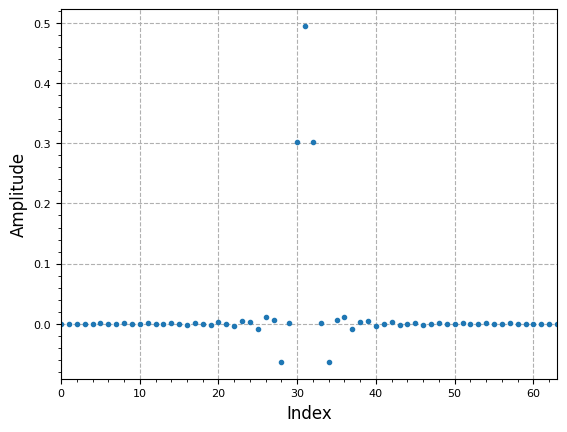

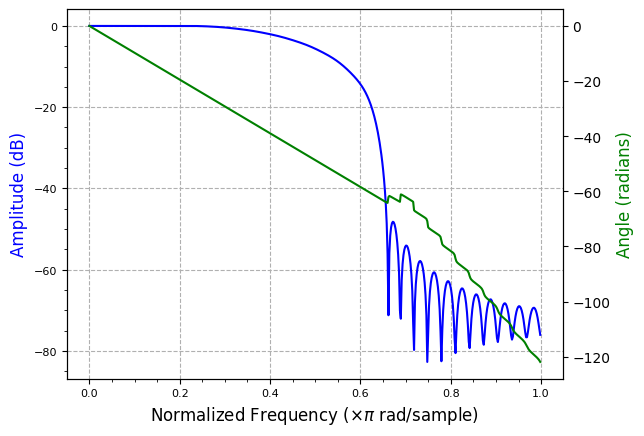

In [2]:
# CCSDS OQPSK SRRC rolloff=0.5: https://public.ccsds.org/Pubs/413x0g3e1.pdf
rrc_test = filter.RootRaisedCosine(17.225e6, 7.5e6, 0.5, 64)
# The matched filter is a time-reversed and conjugated version of the signal
# NOTE: this is moot for a uniform, real filter...
rrc_mf = np.conj(rrc_test[::-1])
plot.filter_coefficients(rrc_mf)
plt.show()

plot.filter_response(rrc_mf)
plt.show()

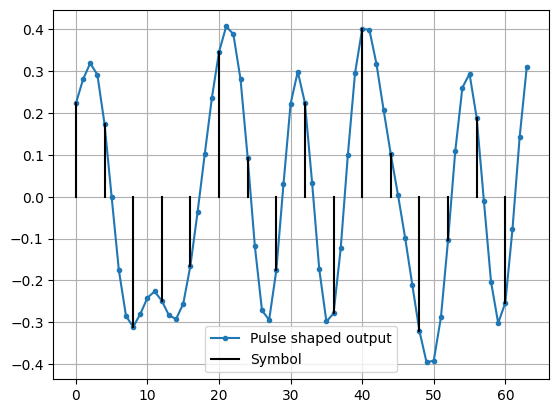

In [3]:
m = 4
qpsk_mod = modulation.MPSKModulation(m)

# simulate random binary input values
num_symbols = 2400
num_disp_sym = 16
rand_symbols = np.random.randint(0, m, num_symbols)
qpsk_symbols = qpsk_mod.modulate(rand_symbols)

L = 4  # Upsample ratio (Samples per Symbol)

def pulse_shape(symbols: np.ndarray, OSR: int, h: np.ndarray):
    """ Similar to np.convolve(x, h, 'same') """
    N = len(h) # filter length (== number of symbols in filter impulse response)
    sym_prepend = np.insert(symbols, 0, symbols[0]*np.ones(N // 2))
    syms = np.append(sym_prepend, symbols[-1]*np.ones(N // 2))

    # zero-insert upsampling
    tx = np.zeros(len(syms) * OSR, dtype=complex)
    tx[::OSR] = syms

    # apply pulse shape filter using direct-form FIR SciPy convolution
    conv_out = signal.lfilter(h, 1, tx)

    # truncate first samples due to prepend and apped to align output with input
    return conv_out[N * OSR:]
 
rc_test = filter.RootRaisedCosine(L, 1, 0.25, 46)
qpsk_tx_filtered = pulse_shape(qpsk_symbols, L, rc_test)

fig, ax = plt.subplots()
ax.plot(np.real(qpsk_tx_filtered[:num_disp_sym * L]), '.-', label='Pulse shaped output')
num_taps = 64
for i in range(num_disp_sym):
    if not i:
        plt.plot([i*L,i*L], [0, np.real(qpsk_tx_filtered[i*L])], color='k', label='Symbol')
    else:
        plt.plot([i*L,i*L], [0, np.real(qpsk_tx_filtered[i*L])], color='k')
plt.grid(True)
plt.legend()
plt.show()

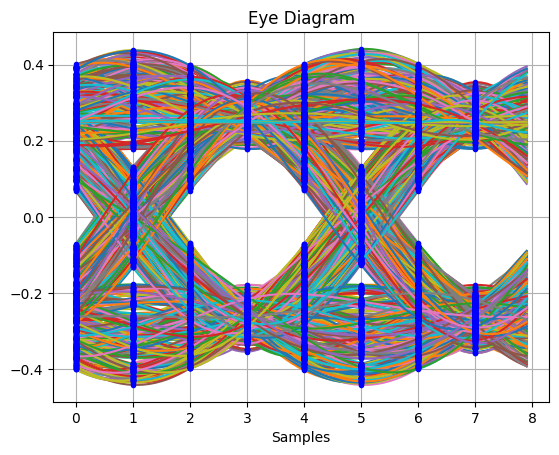

In [4]:
_,_ = plot.eye(qpsk_tx_filtered.real, L)

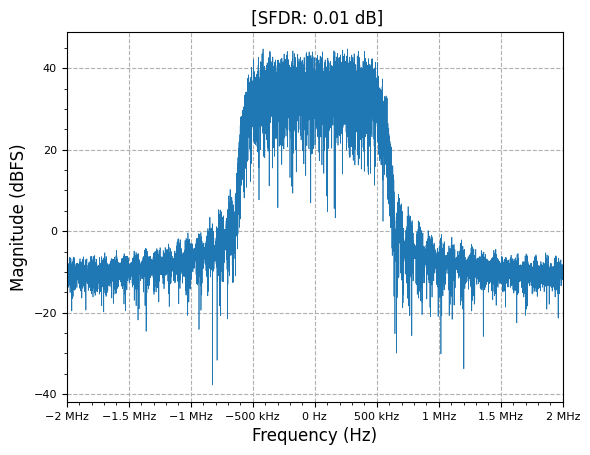

In [5]:
plot.spec_an(qpsk_tx_filtered, fs=L*1e6, fft_shift=True, show_SFDR=False)
plt.show()

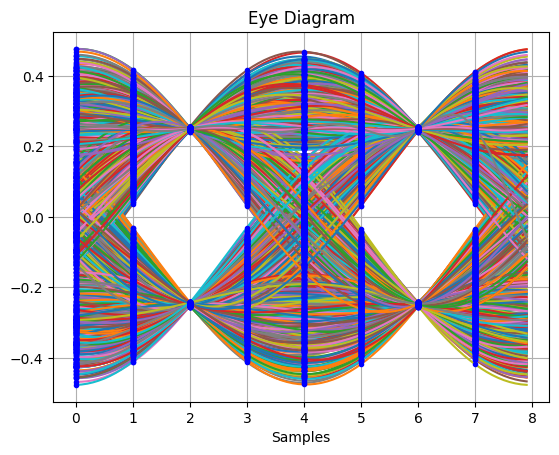

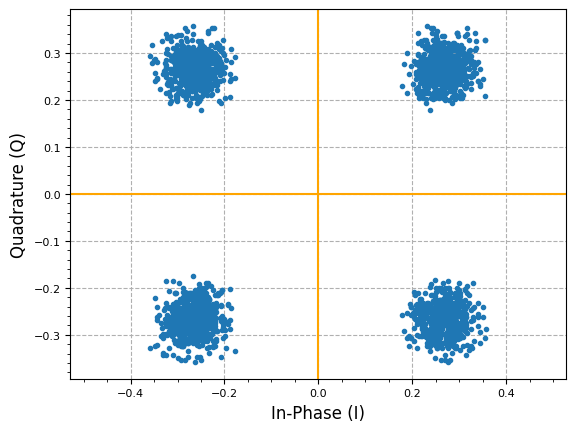

In [6]:
# Pass transmitted waveform through same RRC (matched filter)
rx_shaped = signal.lfilter(rc_test, 1, qpsk_tx_filtered)
# don't plot begining samples while starting filter convolution process
transient = (len(rc_test)//2 + 1) * L
_,_ = plot.eye(rx_shaped.real[transient:], L )

# adjust for best EVM, similar to slicer
timing_offset = 3
plot.IQ(qpsk_tx_filtered[transient + timing_offset::4])
plt.show()

## References

* [Digital Pulse-Shaping Filter Basics - ADI AN-922](https://www.analog.com/media/en/technical-documentation/application-notes/an-922.pdf)
* [Root Raised Cosine (RRC) Filters and Pulse Shaping in Communication Systems - NASA](https://ntrs.nasa.gov/api/citations/20120008631/downloads/20120008631.pdf)
* [Frequency Response of RRC Filter - DSP Stack Exchange](https://dsp.stackexchange.com/questions/51088/pulse-shaping-with-rrc-number-of-taps)
* [Raised Cosine Filtering - MATLAB](https://www.mathworks.com/help/comm/ug/raised-cosine-filtering.html)
* [Raised-Cosine Filter - Wikipedia](https://en.wikipedia.org/wiki/Raised-cosine_filter)
* [The care and feeding of digital, pulse-shaping filters](https://www.nonstopsystems.com/radio/pdf-hell/article-raised-cosine.pdf)
* [Matched Filter - Wikipedia](https://en.wikipedia.org/wiki/Matched_filter)